# BIDMach: basic classification

For this tutorial, we'll BIDMach's GLM (Generalized Linear Model) package. It includes linear regression, logistic regression, and support vector machines (SVMs). The imports below include both BIDMat's matrix classes, and BIDMach machine learning classes. 

In [1]:
import BIDMat.{CMat,CSMat,DMat,Dict,IDict,FMat,FND,GDMat,GMat,GIMat,GSDMat,GSMat,HMat,Image,IMat,Mat,SMat,SBMat,SDMat}
import BIDMat.MatFunctions._
import BIDMat.SciFunctions._
import BIDMat.Solvers._
import BIDMat.JPlotting._
import BIDMach.Learner
import BIDMach.models.{FM,GLM,KMeans,KMeansw,ICA,LDA,LDAgibbs,NMF,RandomForest,SFA}
import BIDMach.datasources.{MatSource,FileSource,SFileSource}
import BIDMach.mixins.{CosineSim,Perplexity,Top,L1Regularizer,L2Regularizer}
import BIDMach.updaters.{ADAGrad,Batch,BatchNorm,IncMult,IncNorm,Telescoping}
import BIDMach.causal.{IPTW}

Mat.checkMKL
Mat.checkCUDA
Mat.plotInline = true
if (Mat.hasCUDA > 0) GPUmem

1 CUDA device found, CUDA version 7.0


(0.16434729,1985216512,12079398912)

## Dataset: Reuters RCV1 V2

The dataset is the widely used Reuters news article dataset RCV1 V2. This dataset and several others are loaded by running the script <code>getdata.sh</code> from the BIDMach/scripts directory. The data include both train and test subsets, and train and test labels (cats). 

In [2]:
var dir = "../data/rcv1/"  // Assumes bidmach is run from BIDMach/tutorials. Adjust to point to the BIDMach/data/rcv1 directory
tic
val train = loadSMat(dir+"docs.smat.lz4")
val cats = loadFMat(dir+"cats.fmat.lz4")
val test = loadSMat(dir+"testdocs.smat.lz4")
val tcats = loadFMat(dir+"testcats.fmat.lz4")
toc

1.662

BIDMach's basic classifiers can invoked like this on data that fits in memory:

In [3]:
val (mm, opts) = GLM.learner(train, cats, GLM.logistic)

BIDMach.models.GLM$LearnOptions@16561485

The last option specifies the type of model, linear, logistic or SVM. The syntax is a little unusual. There are two values returned. The first <code>mm</code> is a "learner" which includes model, optimizer, and mixin classes. The second <code>opts</code> is an options object specialized to that combination of learner components. This design facilitates rapid iteration over model parameters from the command line or notebook. 

The parameters of the model can be viewed and modified by doing <code>opts.what</code>

In [4]:
opts.what
opts.lrate=0.3f

Option Name       Type          Value
===========       ====          =====
addConstFeat      boolean       false
aopts             Opts          null
autoReset         boolean       true
batchSize         int           10000
checkPointFile    String        null
checkPointInterval  float         0.0
cumScore          int           0
debug             int           0
debugMem          boolean       false
dim               int           256
doubleScore       boolean       false
epsilon           float         1.0E-5
evalStep          int           11
featThreshold     Mat           null
featType          int           1
hashBound1        int           1000000
hashBound2        int           1000000
hashFeatures      int           0
initsumsq         float         1.0E-5
iweight           FMat          null
langevin          float         0.0
lim               float         0.0
links             IMat          1,1,1,1,1,1,1,1,1,1,...
lrate             FMat          1
mask              FMat

0.30000

Most of these will work well with their default values. On the other hand, a few have a strong effect on performance. Those include:
<pre>
lrate: the learning rate
batchSize: the minibatch size
npasses: the number of passes over the dataset
</pre>
We will talk about tuning those in a moment. For now lets train the model:

In [5]:
opts.npasses=2
mm.train

corpus perplexity=5582.125391
pass= 0
 2.00%, ll=-0.69315, gf=2.771, secs=0.2, GB=0.02, MB/s=87.73, GPUmem=0.101778
16.00%, ll=-0.06984, gf=9.980, secs=0.5, GB=0.13, MB/s=251.71, GPUmem=0.101778
30.00%, ll=-0.05885, gf=12.012, secs=0.8, GB=0.25, MB/s=298.38, GPUmem=0.101778
44.00%, ll=-0.05025, gf=12.886, secs=1.1, GB=0.36, MB/s=317.98, GPUmem=0.101778
58.00%, ll=-0.04849, gf=13.506, secs=1.4, GB=0.48, MB/s=332.05, GPUmem=0.101778
72.00%, ll=-0.03930, gf=13.878, secs=1.7, GB=0.59, MB/s=340.64, GPUmem=0.101778
87.00%, ll=-0.04346, gf=13.245, secs=2.2, GB=0.70, MB/s=324.72, GPUmem=0.101778
100.00%, ll=-0.03860, gf=13.518, secs=2.4, GB=0.81, MB/s=329.18, GPUmem=0.101431
pass= 1
 2.00%, ll=-0.04507, gf=13.568, secs=2.5, GB=0.83, MB/s=332.35, GPUmem=0.101431
16.00%, ll=-0.03975, gf=13.794, secs=2.8, GB=0.94, MB/s=337.57, GPUmem=0.101431
30.00%, ll=-0.04341, gf=13.941, secs=3.1, GB=1.05, MB/s=341.07, GPUmem=0.101431
44.00%, ll=-0.03979, gf=14.080, secs=3.4, GB=1.17, MB/s=344.27, GPUmem=0.101

The output includes important information about the training cycle:
* Percentage of dataset processed
* Cross-validated log likelihood (or negative loss)
* Overall throughput in gigaflops
* Elapsed time in seconds
* Total Gigabytes processed
* I/O throughput in MB/s
* GPU memory remaining (if using a GPU)

The likelihood is calculated on a set of minibatches that are held out from training on every cycle. So this is a cross-validated likelihood estimate. Cross-validated likelihood will increase initially, but will then flatten and may decrease. There is random variation in the likelihood estimates because we are using SGD. Determining the best point to stop is tricky to do automatically, and is instead left to the analyst. 

To evaluate the model, we build a classifier from it:

In [6]:
val (pp, popts) = GLM.predictor(mm.model, test)

BIDMach.models.GLM$PredOptions@ae4a082

And invoke the predict method on the predictor:

In [7]:
pp.predict

corpus perplexity=65579.335560
Predicting
 3.00%, ll=-0.18303, gf=0.081, secs=0.2, GB=0.00, MB/s= 6.51, GPUmem=0.14
 6.00%, ll=-0.16369, gf=0.158, secs=0.2, GB=0.00, MB/s=12.82, GPUmem=0.14
10.00%, ll=-0.16035, gf=0.225, secs=0.2, GB=0.00, MB/s=18.64, GPUmem=0.14
13.00%, ll=-0.17411, gf=0.301, secs=0.2, GB=0.01, MB/s=24.63, GPUmem=0.14
16.00%, ll=-0.15892, gf=0.373, secs=0.2, GB=0.01, MB/s=30.60, GPUmem=0.14
20.00%, ll=-0.16357, gf=0.438, secs=0.2, GB=0.01, MB/s=36.17, GPUmem=0.14
23.00%, ll=-0.15154, gf=0.502, secs=0.2, GB=0.01, MB/s=41.62, GPUmem=0.14
26.00%, ll=-0.16049, gf=0.566, secs=0.2, GB=0.01, MB/s=47.03, GPUmem=0.14
30.00%, ll=-0.16928, gf=0.635, secs=0.2, GB=0.01, MB/s=52.70, GPUmem=0.14
33.00%, ll=-0.17060, gf=0.702, secs=0.2, GB=0.01, MB/s=58.16, GPUmem=0.14
36.00%, ll=-0.16636, gf=0.768, secs=0.2, GB=0.01, MB/s=63.49, GPUmem=0.14
40.00%, ll=-0.17333, gf=0.828, secs=0.2, GB=0.01, MB/s=68.52, GPUmem=0.14
43.00%, ll=-0.16375, gf=0.892, secs=0.2, GB=0.02, MB/s=73.88, GPUmem=0

Although ll values are printed above, they are not meaningful (there is no target to compare the prediction with). 

We can now compare the accuracy of predictions (preds matrix) with ground truth (the tcats matrix). 

In [8]:
val preds = FMat(pp.preds(0))

    0.051716  2.8286e-15  9.3898e-10  9.3898e-10  0.00024929  8.0685e-12...
    0.011135  3.4162e-05  4.7918e-06  4.7918e-06   0.0059853  9.2513e-08...
     0.78789  2.8876e-12  1.7810e-09  1.7810e-09  1.3463e-05  5.0863e-09...
    0.011328  2.3973e-15  1.1961e-11  1.1961e-11  3.4776e-05  8.7643e-06...
     0.99887  1.0619e-06  2.1314e-09  2.1314e-09  2.3170e-05           1...
  2.0127e-07     0.99854  7.5009e-07  7.5009e-07     0.14460  3.9604e-07...
  1.1595e-05           1      1.0000      1.0000     0.90988  1.4345e-05...
  3.8421e-07  7.1216e-06     0.73840     0.73840    0.062895  4.6554e-11...
          ..          ..          ..          ..          ..          ..


In [9]:
val lls = mean(ln(1e-7f + tcats ∘ preds + (1-tcats) ∘ (1-preds)),2)  // actual logistic likelihood
mean(lls)

-0.039590

A more thorough measure is ROC area:

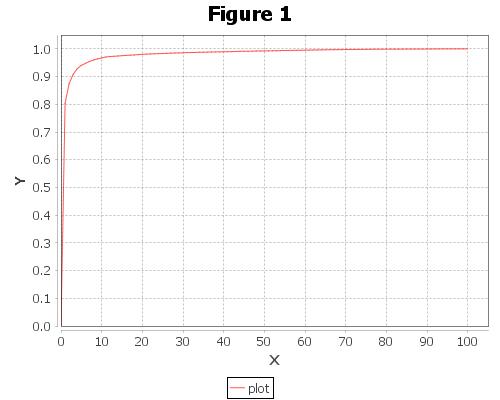

In [10]:
val rocs = roc2(preds, tcats, 1-tcats, 100)   // Compute ROC curves for all categories
plot(rocs(?,6))

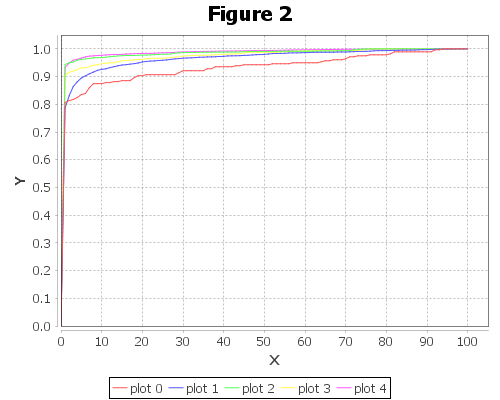

In [11]:
plot(rocs(?,0->5))

In [12]:
val aucs = mean(rocs)

0.92796,0.95949,0.97780,0.96988,0.98077,0.94405,0.97540,0.97547,0.97647,0.94959,0.97718,0.94474,0.86756,0.91574,0.98457,0.96938,0.97628,0.95293,0.91328,0.95620,0.90527,0.91562,0.95315,0.94977,0.97943,0.95953,0.96210,0.95130,0.97605,0.94854,0.94699,0.96866,0.94554,0.96259,0.91478,0.95784,0.90442,0.96816,0.80705,0.94270,0.94160,0.95267,0.66955,0.92352,0.95091,0.92467,0.90882,0.95015,0.96943,0.96349,0.97251,0.97540,0.91864,0.95583,0.93168,0.96431,0.96347,0.61410,0.91780,0.96541,0.98574,0.91007,0.96804,0.76783,0.94777,0.87311,0.95931,0.98108,0.90297,0.98872,0.92896,0.96976,0.88119,0.88600,0.90381,0.93929,0.92118,0.90963,0.96243,0.95381,0.96487,0.88981,0.91170,0.92376,0.93833,0.87769,0.74387,0.93540,0.95893,0.98602,0.95531,0.93069,0.96342,0.97120,0.95280,0.78630,0.69109,0.66667,0.44554,0.98515,0.50000,NaN,NaN

In [13]:
aucs(6)

0.9753971348784144

We could go ahead and start tuning our model, or we automate the process as in the next worksheet.